In [1]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla K80


In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import re
from tqdm import tqdm_notebook

from nltk.corpus import stopwords

from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [3]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 100 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100
GLOVE_DIR = r"glove.twitter.27B.100d.txt"

In [4]:
import os 
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/DATASET AML/')

Mounted at /content/drive


# Import Glove

In [5]:
embeddings_index = {}
f = open(GLOVE_DIR, encoding="utf8")
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")


Loading GloVe from: glove.twitter.27B.100d.txt ...Done.
 Proceeding with Embedding Matrix...

Mounted at /content/drive


#Import Dataset

EDA BINARY

In [6]:
os.chdir('/content/drive/My Drive/DATASET AML/PROJECT/dataset_giusti')

In [15]:
train = pd.read_csv("BINARY_augmented_Trans_undersampling_senza_stopword_FINAL.csv")
train["comment_text"] = train["comment_text"].astype(str)
train.head()

,comment_text,bad
0,reply gender post not guess someone gender unc...,1
1,reference review delete try keep variety diffe...,0
2,reference hi not confuse wpcite current state ...,0
3,block cannot respond lie,1
4,fuck fite edit page youre top class tallywacke...,1


#Tokenization and Embedding

In [16]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train['comment_text'].values)
sequences = tokenizer.texts_to_sequences(train["comment_text"])
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 67071


In [17]:
embeddings_dict = {}

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_dict[word] = embedding_vector
print(" Completed!")

 Completed!


In [18]:
tsne = TSNE(n_components=2, random_state=0)
words =  list(embeddings_dict.keys())
vectors = [embeddings_dict[word] for word in words]

In [19]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

In [20]:
labels = ['bad']
y = to_categorical(train[labels].values)

In [21]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (39388, 100)
Shape of label tensor: (39388, 2)


In [22]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [23]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [15735. 15776.]
validation:  [3956. 3921.]


In [24]:
print('Tokenized sentences: \n', data[20])
print('One hot label: \n', labels[20])

Tokenized sentences: 
 [  912   824  1035  1702   887   236    93    19   323 20118  1450   523
     1    79 29470  9112 29471    46 63205  1443  1669   887  3069   251
     3 10756   197  1669  1078  1426   236 29470   134   400   616  1233
 10756   168 29469  7473  1103    30   387   912   824  1035  1036  1408
  1595  1768    30    23   265   621 10756  4505 63206   152   646 63207
 63208 63209 63210 12783 63211  4072  1200 27178 10756   302   387   621
  1035  1088  2582  1035   146 10620  1340  3143  1230 20626 20346  1280
 20118  3321  1035    18  1920  2135   146  6132  1230 21062 63212   971
  3069  3103 20118  1035]
One hot label: 
 [1. 0.]


In [25]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

 Completed!


#LSTM MODEL

In [26]:
from tensorflow.keras.layers import Bidirectional

In [27]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)
x = (Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer')))(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(2, activation="sigmoid")(x)

In [28]:
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])

In [29]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 4, batch_size=128, validation_data=(x_val, y_val), verbose = 2)

Training progress:
Epoch 1/4
247/247 - 18s - loss: 0.3063 - accuracy: 0.8686 - val_loss: 0.2210 - val_accuracy: 0.9121
Epoch 2/4
247/247 - 8s - loss: 0.2225 - accuracy: 0.9103 - val_loss: 0.2110 - val_accuracy: 0.9138
Epoch 3/4
247/247 - 8s - loss: 0.2056 - accuracy: 0.9173 - val_loss: 0.2028 - val_accuracy: 0.9167
Epoch 4/4
247/247 - 8s - loss: 0.1942 - accuracy: 0.9220 - val_loss: 0.1969 - val_accuracy: 0.9194


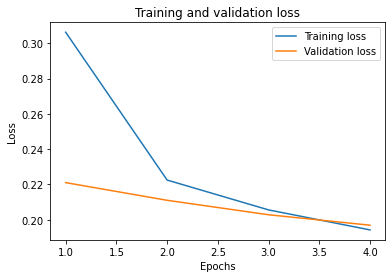

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

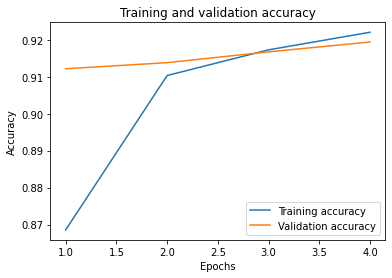

In [31]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

# Test

In [32]:
os.chdir('/content/drive/My Drive/DATASET AML/PROJECT/dataset_giusti/TEST')

In [33]:
test = pd.read_csv("test_binary_senza_stopword.csv")

In [34]:
test

,Unnamed: 0,Unnamed: 0.1,comment_text,bad
0,0,5,thank you for understand i think very highly o...,0
1,1,7,dear god this site be horrible,0
2,2,11,somebody will invariably try to add religion r...,0
3,3,13,it say it right there that it be a type the ty...,0
4,4,14,before add a new product to the list make sure...,0
...,...,...,...,...
63973,63973,153150,jerome i see you never get around to this im n...,0
63974,63974,153151,lucky bastard httpwikimediafoundationorgwikipr...,0
63975,63975,153154,shame on you all you want to speak about gay a...,0
63976,63976,153155,mel gibson be a nazi bitch who make shitty mov...,1


In [35]:

sequences = tokenizer.texts_to_sequences(test["comment_text"].astype(str))


In [36]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

In [37]:
labels = ['bad']
y = to_categorical(test[labels].values)

In [38]:
eval= model.evaluate(data,y)

2000/2000 [==============================] - 32s 16ms/step - loss: 0.4215 - accuracy: 0.8434


In [39]:
performance = model.predict(data)


In [40]:
import sklearn

In [41]:
y_pred =np.round(performance)

In [42]:
sklearn.metrics.recall_score(y, y_pred, average= 'macro')

0.8913474075636055

In [43]:
print(" TEST LOSS: ", performance[0])

 TEST LOSS:  [0.99746287 0.00289343]
